#### Imports

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import cv2
import numpy as np
import math

#### Download ISIC-2019 Testing Data
Download the testing data from https://challenge.isic-archive.com/data/#2019

#### Filter Functions
Grayscale, Hair Removal, Noise Reduction, and Contrast Enhancement

In [2]:
def filter_all_images(image_folder: str, output_folder: str, image_files: list[str]) -> None:
    """
    Apply all filtering functions to a list of image files.
    
    image_files: List of image file names
    """
    for image_file in image_files:
        try:
            filter_image(image_folder, output_folder, image_file)
        except Exception as e:
            print(f"Error processing image {image_file}: {e}")

def filter_image(image_folder: str, output_folder: str, image_file: str) -> None:
    """
    Apply all filtering functions to a single image file.
    
    image_file: Image file name
    """
    image_path = os.path.join(image_folder, image_file)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image: {image_file}")
    else:
        image_gr = grayscale(image)
        image_hr = hair_removal(image_gr)
        image_nr = noise_reduction(image_hr)
        image_ce = contrast_enhancement(image_nr)

        image_final = image_nr
        output_path = os.path.join(output_folder, image_file)
        cv2.imwrite(output_path, image_final)

def grayscale(image: np.ndarray) -> np.ndarray:
    """Convert the image to grayscale."""
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def hair_removal(image: np.ndarray) -> np.ndarray:
    """Apply hair removal filter to the image using the Dull Razor algorithm."""
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))  # creates a kernel for morphing
    blackhat = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, kernel)  # apply blackhat filter (highlights dark regions)
    bhg = cv2.GaussianBlur(blackhat, (9, 9), cv2.BORDER_REPLICATE)  # smooths image
    _, mask = cv2.threshold(bhg, 50, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # creates a binary mask to detect hair-like structure
    image_bgr = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    inpainted_image = cv2.inpaint(image_bgr, mask, 4, cv2.INPAINT_TELEA)
    # Convert back to grayscale
    return cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2GRAY)

def noise_reduction(image: np.ndarray) -> np.ndarray:
    """Apply noise reduction to the image using Median Filtering and Bilateral Filtering."""
    image_mf = cv2.medianBlur(image, 5)  # Apply median filter to reduce salt and pepper noise
    image_bf = cv2.bilateralFilter(image_mf, d=17, sigmaColor=100, sigmaSpace=100)  # Apply bilateral filter to reduce noise while preserving edges
    return image_bf

def contrast_enhancement(image: np.ndarray) -> np.ndarray:
    """Apply contrast enhancement to the image using Histogram Equalization."""
    # Check if the image is grayscale
    if len(image.shape) == 2:
        # Apply Adaptive Histogram Equalization (CLAHE)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        return clahe.apply(image)
    else:
        print("Error: Image is not grayscale, cannot apply histogram equalization.")
        return image

#### Preprocessing Functions
Updating Labeling, Data Augmentation, Resizing

In [3]:
def resize_images(folder: str, target_size=(224, 224)):
    """
    Resize all jpg images in a folder to the target size.

    folder: Path to the folder containing images
    target_size: Tuple specifying the target size (width, height)
    """
    for filename in os.listdir(folder):
        if filename.endswith('.jpg') or filename.endswith('.jpeg'):
            image_path = os.path.join(folder, filename)
            image = cv2.imread(image_path)
            if image is None:
                print(f"Error loading image: {filename}")
                continue
            
            resized_image = cv2.resize(image, target_size)
            cv2.imwrite(image_path, resized_image)  # Save the resized image back to the same path

#### View Functions

In [4]:
def num_melanoma(data_frame: pd.DataFrame) -> int:
    # Count number of melanoma vs non-melanoma
    melanoma_count = data_frame[data_frame["MEL"] == 1].shape[0]
    non_melanoma_count = data_frame[data_frame["MEL"] == 0].shape[0]

    print(f"\nMelanoma images: {melanoma_count}")
    print(f"Non-Melanoma images: {non_melanoma_count}")

    # Percent distribution
    print("\nMEL column class distribution (%):")
    print(data_frame["MEL"].value_counts(normalize=True) * 100)

def view_images(folder: str, image_files: list[str], num=0) -> None:
    """
    View a subset of images from the dataset.

    image_files: List of image file names
    num: Number of images to display
    """
    if num == 0:
        num = len(image_files)
    n_rows = math.ceil(num // 5)
    n_cols = 5
    plt.figure(figsize=(n_cols * 3, n_rows * 5))  # Adjust figure size dynamically
    for i, image_file in enumerate(image_files[:num]):
        image_path = os.path.join(folder, image_file)
        img = mpimg.imread(image_path)
        
        plt.subplot(n_rows, n_cols, i + 1)
        # Check if the image is grayscale
        if len(img.shape) == 2 or (len(img.shape) == 3 and img.shape[2] == 1):
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)
        plt.title(image_file, fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

#### Path Setup

In [9]:
base_path = '/Users/nathanong/Downloads'  # TODO: Update this path to test data
image_folder = os.path.join(base_path, 'ISIC_2019_Test_Input')
labels_path = os.path.join(base_path, 'ISIC_2019_Test_GroundTruth.csv')
output_folder = 'preprocessed_dataset'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

#### View Images

Total .jpg files found: 8238
Sample image names: ['ISIC_0058528.jpg', 'ISIC_0056505.jpg', 'ISIC_0067900.jpg', 'ISIC_0035920.jpg', 'ISIC_0065871.jpg']

Images before preprocessing:


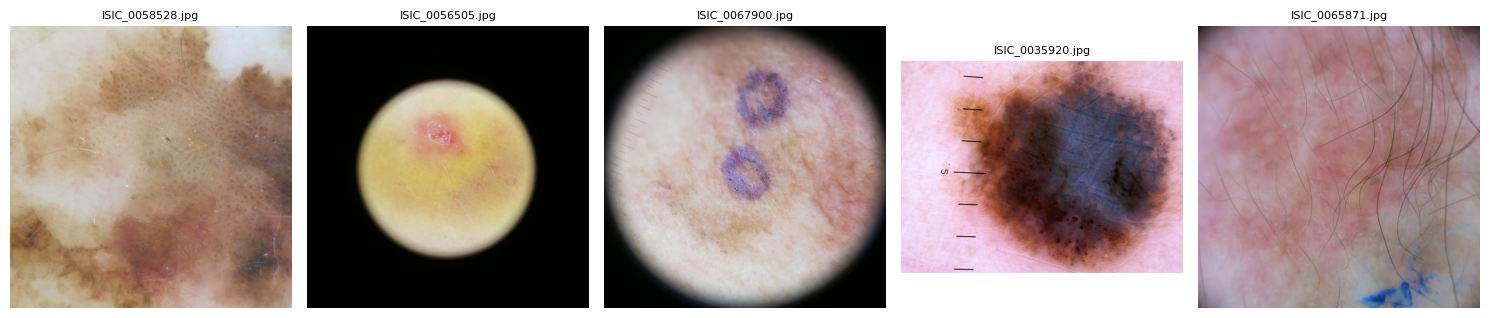

In [10]:
# === Check Images ===
# List only .jpg image files (ignore folders)
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg') and os.path.isfile(os.path.join(image_folder, f))]

print("Total .jpg files found:", len(image_files))
print("Sample image names:", image_files[:5])

# === Visualize First 5 Images ===
print("\nImages before preprocessing:")
view_images(image_folder, image_files, 5)

#### Filter All Images


Images after filtering:


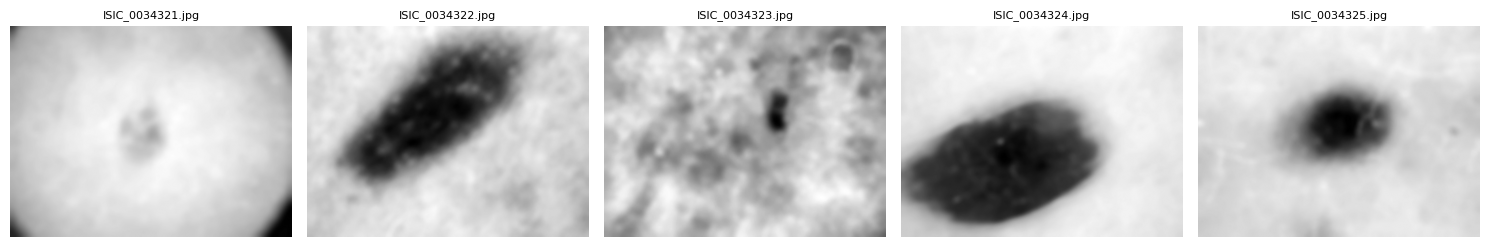

In [7]:
# === Filtering and Preprocessing ===

# Testing with first 5 images
# filter_all_images(image_folder, output_folder, image_files[:5])

filter_all_images(image_folder, output_folder, image_files)
print("\nImages after filtering:")
result_files = [f for f in os.listdir(output_folder) if f.endswith('.jpg') and os.path.isfile(os.path.join(output_folder, f))]
result_files.sort()
view_images(output_folder, result_files, 5)
# view_images(output_folder, result_files)

#### Load DataFrame

In [11]:
# === Load Labels CSV ===
df = pd.read_csv(labels_path)
print("\nTesting labels preview:")
print(df.head())

# === Melanoma vs. Non-Melanoma ===
num_melanoma(df)  # Display the number of melanoma vs non-melanoma images


Testing labels preview:
          image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK  score_weight  \
0  ISIC_0034321  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0           0.0   
1  ISIC_0034322  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0           0.0   
2  ISIC_0034323  0.0  0.0  1.0  0.0  0.0  0.0   0.0  0.0  0.0           0.0   
3  ISIC_0034324  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0           0.0   
4  ISIC_0034325  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0           0.0   

   validation_weight  
0                1.0  
1                1.0  
2                1.0  
3                1.0  
4                1.0  

Melanoma images: 1327
Non-Melanoma images: 6911

MEL column class distribution (%):
MEL
0.0    83.891721
1.0    16.108279
Name: proportion, dtype: float64


#### Resize Images


Resizing images to 224x224...

Total resized images: 8238


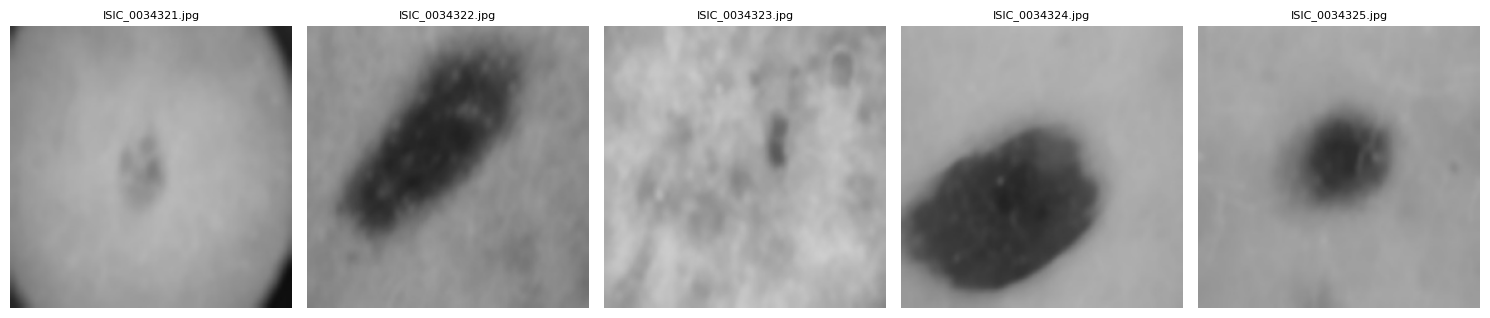

In [12]:
# Resize all images in the output folder to 224x224
print("\nResizing images to 224x224...")
resize_images(output_folder)
# Check resized images
resized_files = [f for f in os.listdir(output_folder) if f.endswith('.jpg') and os.path.isfile(os.path.join(output_folder, f))]
resized_files.sort()
print(f"\nTotal resized images: {len(resized_files)}")
# Visualize first 5 resized images
view_images(output_folder, resized_files, 5)